# Skin Disease

[Dataset link](https://www.kaggle.com/datasets/akshitmadan/various-skin-diseases-dataset)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hrushi11","key":"9b9f258483748efbefebd15f467936bf"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d akshitmadan/various-skin-diseases-dataset

 81% 55.0M/68.2M [00:04<00:01, 12.2MB/s]
100% 68.2M/68.2M [00:04<00:00, 15.7MB/s]


In [ ]:
# downloading helper_functions.py
! wget https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py

--2022-05-20 17:42:45--  https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10139 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.90K  --.-KB/s    in 0s      

2022-05-20 17:42:46 (50.4 MB/s) - ‘helper_functions.py’ saved [10139/10139]



In [ ]:
# Importing Dependancies
import os
import random
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from helper_functions import unzip_data, walk_through_dir, make_confusion_matrix, plot_loss_curves, compare_historys

In [ ]:
# Unzipping the data
unzip_data("/content/various-skin-diseases-dataset.zip")

In [ ]:
# deleting the zip file
!rm various-skin-diseases-dataset.zip

In [ ]:
# To delete extra folders in train
shutil.rmtree("/content/dataset/train/Hairloss")
shutil.rmtree("/content/dataset/train/Nail Fungus")
shutil.rmtree("/content/dataset/train/Skin Allergy")

# To delete extra folders in test
shutil.rmtree("/content/dataset/test/Hairloss")
shutil.rmtree("/content/dataset/test/Nail Fungus")
shutil.rmtree("/content/dataset/test/Skin Allergy")

In [ ]:
# Creating data augmentation layer
data_augmentation = tf.keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name="data_augmentation_layer")

In [ ]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:
# setup data inputs
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

print("Train images :")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE)

print("Testing images :")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE)

Train images :
Found 226 images belonging to 2 classes.
Testing images :
Found 70 images belonging to 2 classes.


In [ ]:
len(train_data), len(test_data)

(8, 3)

In [ ]:
train_data.class_indices

{'Acne': 0, 'Normal': 1}

In [ ]:
# To get all the class names
class_ = train_data.class_indices
class_names = []
for key in class_.keys():
  class_names.append(key)

class_names

['Acne', 'Normal']

In [ ]:
# Setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting input layer 
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer")(x) 
model_1 = tf.keras.Model(inputs, outputs)

# compiling the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/10
8/8 [==============================] - 29s 1s/step - loss: 0.4998 - accuracy: 0.8097 - val_loss: 0.3367 - val_accuracy: 0.9857
Epoch 2/10
8/8 [==============================] - 6s 758ms/step - loss: 0.2587 - accuracy: 0.9513 - val_loss: 0.2061 - val_accuracy: 0.9857
Epoch 3/10
8/8 [==============================] - 5s 592ms/step - loss: 0.1679 - accuracy: 0.9823 - val_loss: 0.1393 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 5s 652ms/step - loss: 0.1281 - accuracy: 0.9912 - val_loss: 0.1056 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 5s 605ms/step - loss: 0.1072 - accuracy: 0.9823 - val_loss: 0.0857 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 5s 615ms/step - loss: 0.0877 - accuracy: 0.9912 - val_loss: 0.0740 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 5s 563ms/step - loss: 0.0693 - accuracy: 0.9912

In [ ]:
import matplotlib.image as mpimg
# Visualizing our data 
def view_random_image(target_dir, target_class):
  # Setup the target directory 
  target_folder = target_dir+target_class

  # Get a random image path 
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # Show the shape of the image 

  return img

['6 (44).jpg']
Image shape: (225, 225, 3)
['2 (49).jpg']
Image shape: (183, 275, 3)


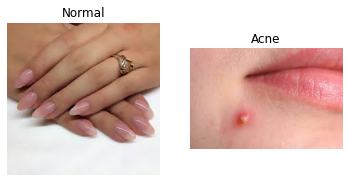

In [ ]:
# Visualize both the data 
plt.figure()
plt.subplot(1, 2, 1)
normal = view_random_image("/content/dataset/train/", "Normal")
plt.subplot(1, 2, 2)
acne = view_random_image("/content/dataset/train/", "Acne")

In [ ]:
# Function for image preprocessing
IMG_SIZE = (224, 224)

def load_and_prep(filepath, normalize=False):
  """
  Image preprocessing, accepts file path and returns
  normalized image.
  """
  # Read the image file
  img = tf.io.read_file(filepath)
  # Converting into tensors
  img = tf.io.decode_image(img)
  # resize image
  img = tf.image.resize(img, IMG_SIZE)
  # Normalizing the image
  if normalize:
    img = img/255.

  return img

In [ ]:
img = load_and_prep("/content/acnnd.jpg")
preds = model_1.predict(tf.expand_dims(img, axis=0))
preds

array([[0.3596042 , 0.64039576]], dtype=float32)

In [ ]:
img = load_and_prep("/content/df.jpg")
preds = model_1.predict(tf.expand_dims(img, axis=0))
preds

array([[0.66951245, 0.33048755]], dtype=float32)

In [ ]:
train_data.class_indices

{'Acne': 0, 'Normal': 1}

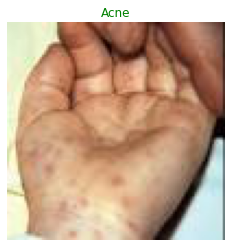

In [ ]:
# Visualizing random images from the dataset
dir_path = "/content/dataset/train"
labels = os.listdir(dir_path)
random_label = random.choice(class_names)
path = os.path.join(dir_path, random_label)
file_path = os.path.join(path, random.choice(os.listdir(path)))

img = plt.imread(file_path)
plt.imshow(img)
plt.title(random_label, color="green")
plt.axis(False);

In [ ]:
all_file_path_acne = []
all_file_path_normal = []
for img_path in os.listdir("/content/dataset/train/Acne"):
  all_file_path_acne.append("/content/dataset/train/Acne/" + img_path)

for img_path in os.listdir("/content/dataset/train/Normal"):
  all_file_path_normal.append("/content/dataset/train/Normal/" + img_path)

all_file_path_acne[:5], all_file_path_normal[:5]

(['/content/dataset/train/Acne/2 (37).jpg',
  '/content/dataset/train/Acne/2 (57).jpg',
  '/content/dataset/train/Acne/2 (13).jpeg',
  '/content/dataset/train/Acne/2 (22).jpg',
  '/content/dataset/train/Acne/2 (16).jpeg'],
 ['/content/dataset/train/Normal/6 (27).jpg',
  '/content/dataset/train/Normal/6 (78).jpg',
  '/content/dataset/train/Normal/6 (5).jpg',
  '/content/dataset/train/Normal/6 (44).jpg',
  '/content/dataset/train/Normal/6 (24).jpeg'])

In [ ]:
len(all_file_path_acne), len(all_file_path_normal)

(82, 156)

In [ ]:
all_file_path = all_file_path_acne + all_file_path_normal
len(all_file_path)

238

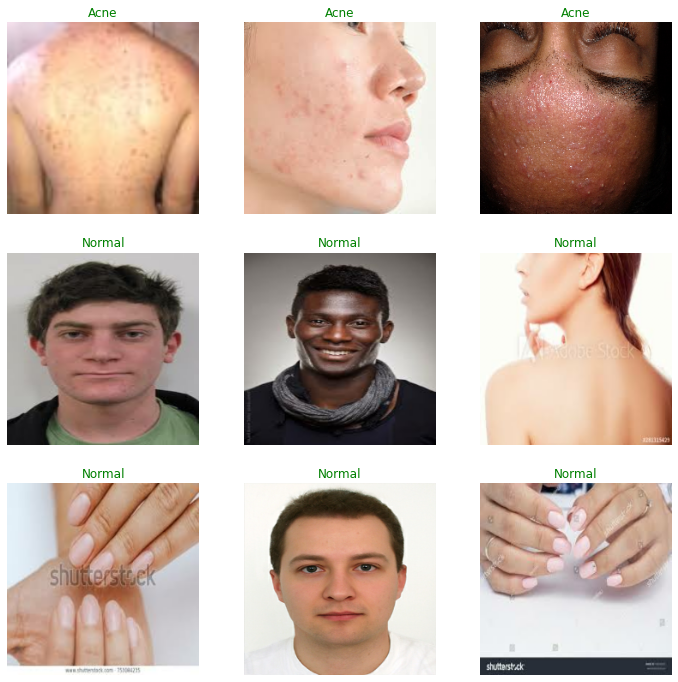

In [ ]:
# Plotting multiple random images
plt.figure(figsize=(12, 12))
for i in range(9):
  random_img_path = random.choice(all_file_path)
  random_label = random_img_path.split("/")[4]
  img = load_and_prep(random_img_path, normalize=True)

  # Plotting the images
  plt.subplot(3, 3, i+1)
  plt.imshow(img)
  plt.title(random_label, color="green")
  plt.axis(False);

In [ ]:
model_1.save("/content/drive/MyDrive/Skin_Disease_Model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Skin_Disease_Model/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Skin Segmentation

Color Information
{'cluster_index': 4,
 'color': [119.32727272726879, 82.16481283422343, 71.96620320855897],
 'color_percentage': 0.2661673833186206}

{'cluster_index': 1,
 'color': [141.0686184812402, 97.00034309240498, 83.93252516011395],
 'color_percentage': 0.24805649685337586}

{'cluster_index': 3,
 'color': [161.52175597159442, 113.2460942543564, 99.79832149774526],
 'color_percentage': 0.21949483156306063}

{'cluster_index': 0,
 'color': [95.28414279784207, 65.60024906600218, 61.62204234122032],
 'color_percentage': 0.13885012956687645}

{'cluster_index': 2,
 'color': [180.7713004484305, 130.4464125560526, 118.2571748878969],
 'color_percentage': 0.12743115869806645}

Color Bar


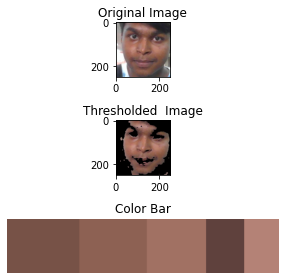

In [ ]:

import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt


def extractSkin(image):
    # Taking a copy of the image
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)


def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)


def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar


"""## Section Two.4.2 : Putting it All together: Pretty Print
The function makes print out the color information in a readable manner
"""


def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()


# Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
image = imutils.url_to_image(
    "https://i.ibb.co/n7xH090/pr.jpg")

# Resize image to a width of 250
image = imutils.resize(image, width=250)

# Show image
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
# plt.show()

# Apply Skin Mask
skin = extractSkin(image)

plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")
# plt.show()

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()